# Classification and PCA Lab

$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
#from PIL import Image

### Setting up some code

In doing homework so far you have probably seen strange behaviours when you run and rerun code. This happens in the jupyter notebook because one is generally using global variables, and you might change a value 10 cells down and then rerun a cell 10 cells before. 

To work around such behavior. encapsulate code withon functions and minimize your use of global variables!

In [2]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

A function to plot the points on the training and test set, and the prediction regions associated with a classifier that has 2 features. Adapted from scikit-learn examples.

In [3]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

A function to add contours to such a plot. I use it while showing predictions as opposed to the default "actual test values" in `points_plot`.

In [4]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%5.4f', colors = 'k', fontsize=14, axes=ax)
    return ax 

### Digits dataset: constructing a classification dataset

This problem is adapted from Jake Vanderpls's tutorial at pydata:  (http://nbviewer.jupyter.org/github/jakevdp/sklearn_pydata2015/blob/master/notebooks/02.2-Basic-Principles.ipynb)

The classification problem there is a multiway digit classification problem

In [5]:
from sklearn import datasets
digits = datasets.load_digits()
digits.images.shape

(1797, 8, 8)

In [6]:
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

This code, taken from Jake's notebook above, plots the images against the targets so that we can see what we are dealing with.

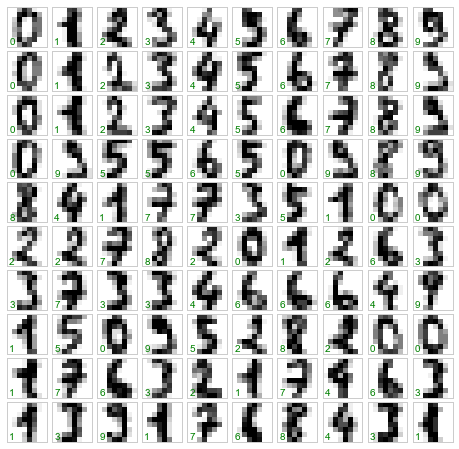

In [7]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')
    ax.set_xticks([])
    ax.set_yticks([])

In [8]:
d2d = digits.images.reshape(1797,64,)

In [9]:
d2d[0].shape, d2d.shape

((64,), (1797, 64))

In [10]:
df = pd.DataFrame(d2d)
df['target'] = digits.target
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


In [11]:
df.groupby('target').count()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178
1,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182
2,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177
3,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183
4,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181
5,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182
6,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181
7,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179
8,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174


> YOUR CODE HERE: To create a stripped down problem for this lab, let us take 2 numbers and try and distinguish them between images. Lets take 8 and 9. make a dtaframe called `dftwo` for this

In [12]:
dftwo = df[df.target.isin([8, 9])]

In [13]:
dftwo.shape

(354, 65)

### Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [15]:
itrain, itest = train_test_split(range(dftwo.shape[0]), test_size=0.4)
set1={}
set1['Xtrain'] = dftwo[list(range(64))].iloc[itrain, :]
set1['Xtest'] = dftwo[list(range(64))].iloc[itest, :]
set1['ytrain'] = dftwo.target.iloc[itrain]==8
set1['ytest'] = dftwo.target.iloc[itest]==8

> YOUR TURN HERE: Carry out an unregularized logistic regression and calculate the score on the `set1` test set.

In [16]:
logit = LogisticRegression(C=1e9)
logit.fit(set1['Xtrain'], set1['ytrain'])
print('Test set accuracy = {:.2f}%'.format(
    100 * logit.score(set1['Xtest'], set1['ytest'])))

Test set accuracy = 98.59%


### Logistic Regression using Cross Validation and Regularization

A function to grid search on parameters while doing cross-validation. Note we return the grid-search meta estimator. Be default `GridSearchCV` will refit on the entire training set. Note the use of `scoring`, which will allow for a use of a different scoring function on the cross-validation set than the loss used to train the model on the training set. (Kevin talked about this in class...and the default in `sklearn` is to use the 1-0 loss for scoring on the validation sets, and the log-loss for example in `LogisticRegression`, for training and parameter estimation.

I keel these separate in my head as **estimation** and **decision** losses. After all, classification requires you to make a decision as to what threshold you will choose.

In [17]:
from sklearn.model_selection import GridSearchCV
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5, scoring=None):
    if not scoring:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=scoring)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    return gs

`do_classify` is an omnibus function which will take a dataframe, a set of column names to use as features, a name for the target, and do the entire machine learning process for you. For the reason of comparing classifiers, it can take an existing testing and training set as well. If you ask it to, it will standardize as well.

This was what I had earlier and refactored. What more could you do?

In [18]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, n_folds=5, standardize=False, test_size=0.4, sets=None, scoring=None):
    if sets:
        Xtrain, Xtest, ytrain, ytest = sets['Xtrain'], sets['Xtest'], sets['ytrain'], sets['ytest']
    else:       
        subdf=indf[featurenames]
        y=(indf[targetname].values==target1val)*1
        # do it stratified? TODO
        itrain, itest = train_test_split(range(subdf.shape[0]), test_size=test_size)
        if standardize:
            dftrain=(subdf.iloc[itrain] - subdf.iloc[itrain].mean())/subdf.iloc[itrain].std()
            dftest=(subdf.iloc[itest] - subdf.iloc[itrain].mean())/subdf.iloc[itrain].std()
        else:
            dftrain=subdf.iloc[itrain]
            dftest=subdf.iloc[itest]
        Xtrain, Xtest, ytrain, ytest = dftrain.values, dftest.values, y[itrain], y[itest]
    clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, scoring=scoring)
    training_score = clf.score(Xtrain, ytrain)
    test_score = clf.score(Xtest, ytest)
    print("Score on training data: %0.2f" % (training_score))
    print("Score on test data:     %0.2f" % (test_score))
    return clf, Xtrain, ytrain, Xtest, ytest

So we refactor:

In [19]:
def classify_with_sets(clf, parameters, sets, n_folds = 5, scoring=None):
    Xtrain, Xtest, ytrain, ytest = sets['Xtrain'], sets['Xtest'], sets['ytrain'], sets['ytest']
    gs = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, scoring=scoring)
    training_score = gs.score(Xtrain, ytrain)
    test_score = gs.score(Xtest, ytest)
    print("Score on training data: %0.2f" % (training_score))
    print("Score on test data:     %0.2f" % (test_score))
    return gs

In [20]:
def classify_from_dataframe(clf, parameters, indf, featurenames, targetname, target1val, n_folds=5, standardize=False, test_size=0.4, scoring=None):
    subdf=indf[featurenames]
    y=(indf[targetname].values==target1val)*1
    itrain, itest = train_test_split(range(subdf.shape[0]), test_size=test_size)
    inset = {}
    if standardize:
        Xtr = (subdf.iloc[itrain] - subdf.iloc[itrain].mean())/subdf.iloc[itrain].std()
        inset['Xtrain'] = Xtr.values
        Xte = (subdf.iloc[itest] - subdf.iloc[itrain].mean())/subdf.iloc[itrain].std()
        inset['Xtest'] = Xte.values
    else:
        inset['Xtrain'] = subdf.iloc[itrain].values
        inset['Xtest'] = subdf.iloc[itest].values
    inset['ytrain'] = y[itrain]
    inset['ytest'] = y[itest]
    clf = classify_with_sets(clf, parameters, inset, n_folds=n_folds, scoring=scoring)
    return clf, inset

In [21]:
cvals = [1e-20, 1e-15, 1e-10, 1e-5, 1e-3, 1e-1, 1, 10, 100, 10000, 100000]

In [22]:
digitstwo_log_set1 = classify_with_sets(
    LogisticRegression(), 
    {"C": cvals},  
    set1,
n_folds=5) 

BEST PARAMS {'C': 0.1}
Score on training data: 1.00
Score on test data:     0.99


### The confusion matrix: comparing classifiers

We have written two classifiers. A classifier will get some samples right, and some wrong. Generally we see which ones it gets right and which ones it gets wrong on the test set. There,

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix from these which lookslike this:

![hwimages](./images/confusionmatrix.png)


IMPORTANT NOTE: In sklearn, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`

> YOUR TURN NOW: Calculate the confusion matrix for the regularized logistic regression

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(set1['ytest'], digitstwo_log_set1.predict(set1['Xtest']))

array([[60,  2],
       [ 0, 80]], dtype=int64)

> YOUR TURN NOW: As an exercise to do this completely with a new train/test split done directly on a dataframe. Call your classifier/estimator `digitstwo_log` and your training/test sets dictionary as `set2`. Compute the confusion matrix for this `set2`

In [24]:
digitstwo_log_set2, set2 = classify_from_dataframe(
    LogisticRegression(),
    {"C": cvals},
    dftwo,
    dftwo.columns.drop('target').values,
    'target',
    8,
    n_folds=5)

BEST PARAMS {'C': 0.1}
Score on training data: 1.00
Score on test data:     1.00


In [25]:
confusion_matrix(set2['ytest'], digitstwo_log_set2.predict(set2['Xtest']))

array([[80,  0],
       [ 0, 62]], dtype=int64)

From the department of not-kosher things to do, (why?) we calculate the performance of this classifier on `set1`.

In [26]:
confusion_matrix(set1['ytest'], digitstwo_log_set2.predict(set1['Xtest']))

array([[62,  0],
       [ 0, 80]], dtype=int64)

### Plotting scores against hyper-parameters

Finally `plot_scores` takes the output of a grid search on one parameter, and plots for you a graph showing the test performance against the parameter. You could augment this with a training set diagram if you like.

In [27]:
def plot_scores(fitmodel, pname):
    params = [d[pname] for d in fitmodel.cv_results_['params']]
    scores = fitmodel.cv_results_['mean_test_score']
    stds = fitmodel.cv_results_['std_test_score']
    plt.plot(params, scores,'.-');
    plt.fill_between(params, scores - stds, scores + stds, alpha=0.3);

(0.6, 1)

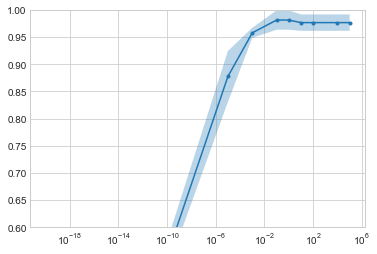

In [28]:
plot_scores(digitstwo_log_set2, 'C')
plt.xscale('log')
plt.ylim(0.6,1)

(0.6, 1)

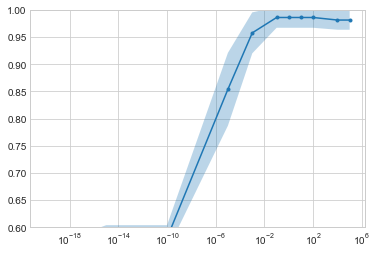

In [29]:
plot_scores(digitstwo_log_set1, 'C')
plt.xscale('log')
plt.ylim(0.6,1)

## Feature engineering

Our images here are relatively small, but in general you will have as many features as pizels multiplied by the color channels. This is a lot of features! Having too many features can lead to overfitting.

Indeed, it is possible to have more features than data points. Thus there is a high chance that a few attributes will correlate with $y$ purely coincidentally!
[^Having lots of images, or "big-data" helps in combatting overfitting!]

We need to do something similar to what happened in the regularized regression or classification here! We will engage in some *a-priori* feature selection that will reduce the dimensionality of the problem. The idea we'll use here is something called **Principal Components Analysis**, or PCA.

PCA is an unsupervized learning technique. The basic idea behind PCA is to rotate the co-ordinate axes of the feature space. We first find the direction in which the data varies the most. We set up one co-ordinate axes along this direction, which is called the first principal component. We then look for a perpendicular direction in which the data varies the second most. This is the second principal component. The diagram illustrates this process. There are as many principal components as the feature dimension: all we have done is a rotation.

![pcanim](https://i.stack.imgur.com/Q7HIP.gif)

(diagram taken from http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues which also has nice discussions)

How does this then achieve feature selection? We decide on a threshold of variation; once the variation in a particular direction falls below a certain number, we get rid of all the co-ordinate axes after that principal component. For example, if the variation falls below 10% after the third axes, and we decide that 10% is an acceptable cutoff, we remove all dimensions from the fourth dimension onwards. In other words, we took our higher dimensional problem and projected it onto a 3 dimensional **subspace**.

These two ideas illustrate one of the most important reasons that learning is even feasible: we believe that **most datasets, in either their unsupervized form $\{\v{x\}}$, or their supervized form $\{y, \v{x}\}$, live on a lower dimensional subspace**. If we can find this subspace, we can then hope to find a method which respectively separates or fits the data.

In [30]:
from sklearn.decomposition import PCA

The explained variance ratio `pca.explained_variance_ratio_` tells us how much of the variation in the features is explained by these 60 features. When we sum it up over the features, we see that 94% is explained: good enough to go down to a 60 dimensional space from a 136452 dimensional one!

We can see the individual variances as we increase the dimensionality:

The first dimension accounts for 35% of the variation, the second 6%, and it goes steadily down from there.

Let us create a dataframe with these 16 features labelled pc1,pc2...,pc60 and the labels of the sample:

Lets see what these principal components look like:

In [31]:
def normit(a):
    a=(a - a.min())/(a.max() -a.min())
    a=a*256
    return np.round(a)
def getNC(pc, j):
    size=8*8
    g=pc.components_[j][0:size]
    g=normit(g)
    return g
def display_component(pc, j):
    g = getNC(pc,j)
    print(g.shape)
    plt.imshow(g.reshape(8,8), cmap='binary')
    plt.xticks([])
    plt.yticks([])

You might be a bit confused: we needed to use 16 components to explain 90% of the variation in the features, but only 1 or 2 components to separate checks from dollars? This is because PCA is unsupervised: the only variation we are explaining is the variation in the 64 dimensional feature space. We are not explaining the variation in the $y$ or the label, and it might turn out, as it does in this case, that with the additional information in $y$, the dimensionality needed for classification is much lower.

We could thus choose just the first few principal components to make our classifier. For the purposes of this lab, since two components can be easily visualized (even though adding some more features may leads to better separability), we'll go with learning a 2-dimensional classifier in the `pc1` and `pc2` dimensions! 

In [32]:
pca_digits = PCA(n_components=16)
X2 = pca_digits.fit_transform(dftwo[list(range(64))].values)

In [33]:
X2

array([[  8.10074916, -12.64316361,  -9.83186365, ...,  -6.39622448,
          2.91430606,   3.03393189],
       [ -7.78776559,  -2.39012062,   1.23238419, ...,  -1.78805575,
          6.7640055 ,   1.98202634],
       [ 19.46405435,  -1.87676635,  18.32405879, ...,  -4.28825415,
          0.26444744,  -3.05586919],
       ...,
       [ 21.77086235,  -1.9423298 ,  -9.28004666, ...,   7.83680897,
          0.35154329,   0.67955995],
       [-10.3206343 ,   5.12417443, -11.60536506, ...,  -4.9529466 ,
          4.10884209,  -1.99159556],
       [  6.03537496, -13.5593368 , -10.46292768, ...,  10.20194107,
          1.36981176,  -1.89405026]])

In [34]:
print(pca_digits.explained_variance_ratio_.sum())

0.8674199531492718


In [35]:
100*pca_digits.explained_variance_ratio_

array([23.00052155, 11.765007  ,  8.34864885,  8.09763762,  5.97655574,
        5.17744746,  4.71192878,  3.76858281,  3.12659485,  2.51728187,
        2.22388241,  1.9821117 ,  1.8017826 ,  1.50450989,  1.42841532,
        1.31108685])

(64,)


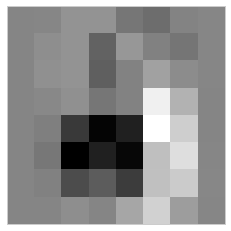

In [36]:
display_component(pca_digits, 0)

(64,)


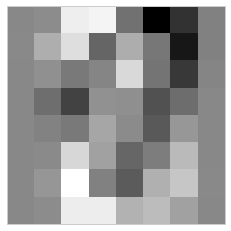

In [37]:
display_component(pca_digits, 1)

(64,)


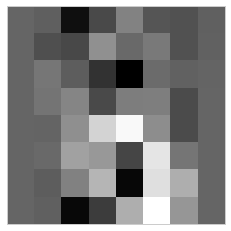

In [38]:
display_component(pca_digits, 2)

In [39]:
dfpca = pd.DataFrame({"target":dftwo.target})
for i in range(pca_digits.explained_variance_ratio_.shape[0]):
    dfpca["pc%i" % (i+1)] = X2[:,i]
dfpca.head()

,target,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
8,8,8.100749,-12.643164,-9.831864,6.692871,-3.471527,3.722768,-10.171100,8.775908,1.380974,-0.662946,1.901084,2.374823,1.013113,-6.396224,2.914306,3.033932
9,9,-7.787766,-2.390121,1.232384,0.226784,-6.408476,19.245410,1.592424,-8.484930,8.525914,10.055121,-1.900405,0.161894,5.406795,-1.788056,6.764006,1.982026
18,8,19.464054,-1.876766,18.324059,7.806491,8.306177,-2.014978,-4.623936,-2.192764,2.550730,7.417850,-3.131096,-0.202411,-2.599265,-4.288254,0.264447,-3.055869
19,9,-17.184131,-10.020684,7.893574,18.052571,12.480299,8.260674,11.657183,4.071840,-4.245667,-1.840670,0.887761,-1.153710,5.404469,6.314952,1.121171,-3.331985
28,8,17.409815,-4.833887,0.694249,8.513341,-5.006003,7.247761,-9.893737,6.411986,9.152888,4.721105,2.157310,-3.184879,-5.303092,-1.991405,2.337659,-0.688857


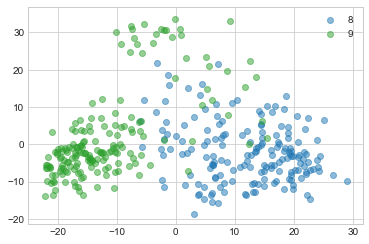

In [40]:
colors = [c0, c2]
for label, color in zip(dfpca['target'].unique(), colors):
    mask = dfpca['target']==label
    plt.scatter(dfpca[mask]['pc1'], dfpca[mask]['pc2'], c=color, label=label, alpha=0.5)
plt.legend()

> YOUR CODE NOW: Do a regularized Logistic Regression using the first two principal components. Store the classifier in `digitspca_log2` and the sets in `setf`

In [41]:
digitspca_log2, setf = classify_from_dataframe(
    LogisticRegression(),
    {"C": cvals},
    dfpca,
    ['pc1', 'pc2'],
    'target',
    8,
    n_folds=5)

BEST PARAMS {'C': 1}
Score on training data: 0.94
Score on test data:     0.89


We use points plot to see misclassification and the decision boundary:

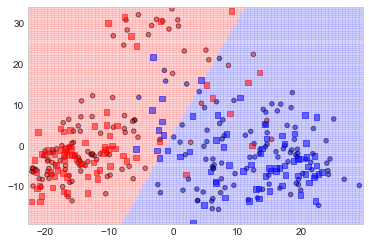

In [42]:
plt.figure()
ax=plt.gca()
points_plot(ax, setf['Xtrain'], setf['Xtest'], setf['ytrain'], setf['ytest'], digitspca_log2, alpha=0.5, psize=20);

And a probability contour plot to see probabilities

c:\users\covuworie\.virtualenvs\a-2017-asnab769\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'axes'
  s)
c:\users\covuworie\.virtualenvs\a-2017-asnab769\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'axes'
  s)


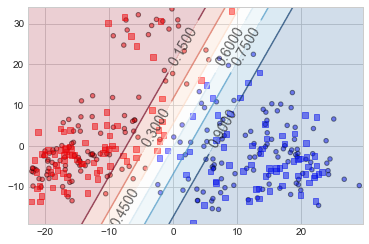

In [43]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax,  setf['Xtrain'], setf['Xtest'], setf['ytrain'], setf['ytest'], digitspca_log2, alpha=0.5, psize=20);

And a scores plot to see the hyper-parameter landscape.

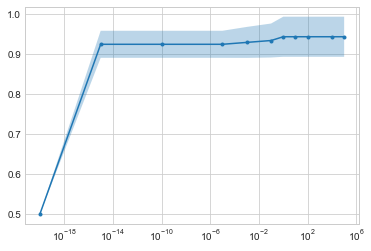

In [44]:
plot_scores(digitspca_log2, 'C')
plt.xscale('log')

And a confusion matrix...

In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix(setf['ytest'], digitspca_log2.predict(setf['Xtest']), )

array([[67,  7],
       [ 9, 59]], dtype=int64)